In [1]:
import nltk.data
import operator
import string
import math
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import random

from nltk.corpus import stopwords
from nltk.corpus import wordnet
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()


## Asociación de palabras

In [2]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def tokenize(text):
    res = []
    tags = []
    sentences = sent_detector.tokenize(text.lower())
    for sentence in sentences:
        text = nltk.word_tokenize(sentence)
        pos_tags = nltk.pos_tag(text)
        for pos_tag in pos_tags:
            tag = get_wordnet_pos(pos_tag[1])
            if not tag is None:
                res.append(wordnet_lemmatizer.lemmatize(pos_tag[0], tag))
                tags.append(pos_tag)
    return res, tags


### Levantar el corpus AP, separando cada noticia como un elemento distinto en un diccionario (``<DOCNO>``: ``<TEXT>``)

In [3]:
apCorpus = {}
with open('ap/ap.txt', 'r') as ap:
    nextDoc = ap.readline()
    while nextDoc:
        docNumber = ap.readline().split(' ')[1]
        ap.readline()
        text = ap.readline().strip()
        ap.readline()
        ap.readline()
        apCorpus[docNumber], _ = tokenize(text)
        nextDoc = ap.readline()


### Calcular el tamaño del vocabulario

In [4]:
apWords = set()
apWordsFrequencies = {}
apCorpusSize = 0
for _, text in apCorpus.iteritems():
    apCorpusSize += len(text)
    tokens = set(text)
    apWords |= tokens
    for word in tokens:
        if not word in apWordsFrequencies:
            apWordsFrequencies[word] = 0
        apWordsFrequencies[word] += text.count(word)

print 'Tamaño del vocabulario:', len(apWords)
print 'Tamaño del corpus:', apCorpusSize

Tamaño del vocabulario: 32231
Tamaño del corpus: 571642


### Para las 500 palabras con más apariciones, calcular el par más asociado según la medida presentada

In [5]:
apTop500Freq = []
for i, (word, count) in enumerate(sorted(apWordsFrequencies.iteritems(), key=operator.itemgetter(1), reverse = True)):
    if i >= 500:
        break
    apTop500Freq.append(word)
print apTop500Freq

[u'be', u'say', u'have', 'not', 'year', u'do', 'i', 'state', 'new', 'percent', 'more', 'people', 'also', 'other', "n't", 'up', 'government', 'president', 'u.s.', 'make', 'official', 'last', u'report', 'go', u'take', "'s", '_', u'time', 'soviet', 'bush', u'day', 'first', 'police', u'include', u'get', 'american', u'tell', 'company', 'week', 'united', 'use', 'today', u'work', u'call', 'country', 'month', 'only', u'give', 'group', 'force', u'come', 'most', u'plan', 'national', 'city', 'house', 'party', 'out', 'thursday', 'court', u'price', 'down', 'member', 'market', u'high', 'tuesday', 'federal', u'issue', 'monday', u'leader', 'friday', u'know', 'wednesday', 'home', 'want', 'think', 'department', 'many', 'union', u'begin', 'now', 'news', 'find', u'nation', u'charge', 'end', u'service', 'york', u'show', u'leave', 'good', u'ask', 'just', u'right', u'hold', 'program', 'world', 'case', 'military', 'stock', u'kill', 'office', 'help', 'south', 'trade', u'support', 'former', 'increase', 'late', 

In [6]:
window = 5
bigram_measures = nltk.collocations.BigramAssocMeasures()
finders = {}
for doc, text in apCorpus.iteritems():
    finder = nltk.collocations.BigramCollocationFinder.from_words(text, window_size = window)
    finder.apply_ngram_filter(lambda w1, w2: w1 not in apTop500Freq or w2 not in apTop500Freq)
    finders[doc] = finder


In [7]:
sum_scores = {}
for _, finder in finders.iteritems():
    for score in finder.score_ngrams(bigram_measures.pmi):
        tupled = tuple(sorted(score[0]))
        if not tupled in sum_scores:
            sum_scores[tupled] = (score[1], 1)
        else:
            sum_scores[tupled] = (sum_scores[tupled][0] + score[1], sum_scores[tupled][1] + 1)

for pair, scores in sum_scores.iteritems():
    sum_scores[pair] = scores[0] / float(scores[1])

maximum = max(sum_scores, key = sum_scores.get)
print(maximum, sum_scores[maximum])

(('germany', u'plan'), 7.596189756144411)


In [8]:
# def f2(x, y):
#     res = 0
#     for _, text in apCorpus.iteritems():
#         for ind in [i for i, w in enumerate(text) if w == x]:
#             for j in range(1, window + 1):
#                 if ind + j < len(text) and text[ind+j] == y:
#                     res += 1
#     return float(res)

# def f1(x):
#     return float(apWordsFrequencies[x])
    
# def I(x, y):
#     p_x_y = f2(x,y) / (apCorpusSize * (window - 1))
#     p_x = f1(x) / apCorpusSize
#     p_y = f1(y) / apCorpusSize
#     factor = p_x_y / (p_x * p_y)
#     if factor > 0:
#         return math.log(factor, 2.0)
#     return 0.0

# max_pair_value = 0
# max_pair = None
# for i in range(500):
#     print i
#     for j in range(i + 1, 500):
#         new_I = I(apTop500Freq[i], apTop500Freq[j])
#         if max_pair_value < new_I:
#             max_pair_value = new_I
#             max_pair = (apTop500Freq[i], apTop500Freq[j])
# print max_pair, max_pair_value

## Información Léxica

### Procesar el libro de Darwin ON THE ORIGIN OF SPECIES, tokenizando eliminando signos de puntuación

In [51]:
darwin_tokens = None
darwin_tags = None
word_freq_darwin = {}
with open('darwin/ONTHEORIGINOFSPECIES.txt', 'r') as darwintext:
    darwin_tokens, darwin_tags = tokenize(darwintext.read().decode('utf-8'))
    for w in set(darwin_tokens):
        word_freq_darwin[w] = darwin_tokens.count(w)


### Siguiendo el artículo, calcular la autocorrelación para estimar la distribución de las palabras: 'plant', 'instinct', 'more' a lo largo del texto

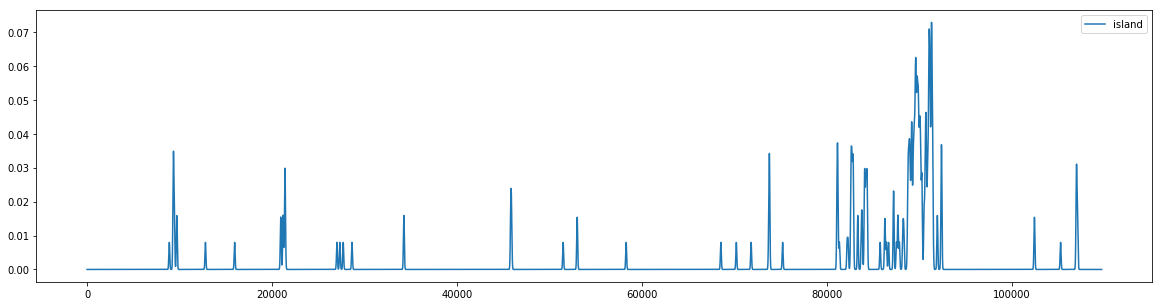

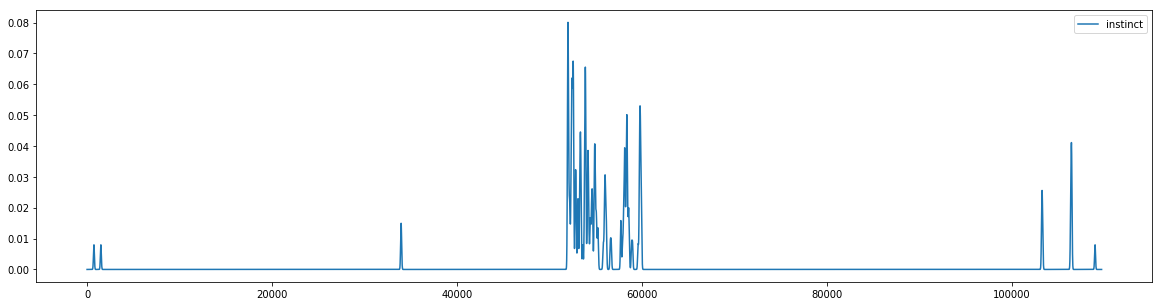

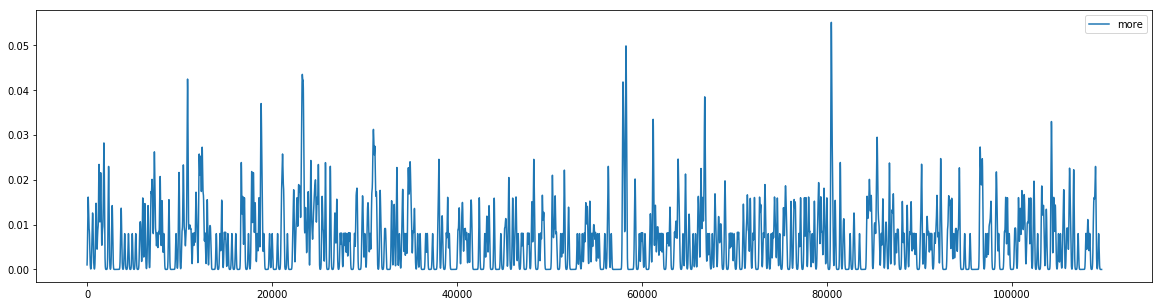

In [10]:
relevant_words = ['island', 'instinct', 'more']
plant_occurrences = [1 if w == relevant_words[0] else 0 for w in darwin_tokens]
instinct_occurrences = [1 if w == relevant_words[1] else 0 for w in darwin_tokens]
more_occurrences = [1 if w == relevant_words[2] else 0 for w in darwin_tokens]

sigma = 50
from astropy.convolution import convolve, Gaussian1DKernel
gauss_kernel = Gaussian1DKernel(50)
smoothed_plant = convolve(plant_occurrences, gauss_kernel)
smoothed_instinct = convolve(instinct_occurrences, gauss_kernel)
smoothed_more = convolve(more_occurrences, gauss_kernel)

plt.subplots(figsize=(20,5))
plt.plot(smoothed_plant, label = relevant_words[0])
plt.legend()
plt.show()

plt.subplots(figsize=(20,5))
plt.plot(smoothed_instinct, label = relevant_words[1])
plt.legend()
plt.show()

plt.subplots(figsize=(20,5))
plt.plot(smoothed_more, label = relevant_words[2])
plt.legend()
plt.show()

### Armar una función que reciba una lista de tokens, una lista de palabras y un tamaño de ventana y devuelva una lista de probabilidades de encontrar la palabra en cada ventana para cada palabra pasada por parámetro

In [11]:
def prob_in_window(tokens, words, window_size):
    res = {}
    chunks = [tokens[i:i + window_size] for i in xrange(0, len(tokens), window_size)]
    for i, chunk in enumerate(chunks):
        probs_in_chunk = {}
        for w in words:
            probs_in_chunk[w] = chunk.count(w) / float(len(chunk))
        res[i] = probs_in_chunk
    return res


### Calcular la entropía de la distribución de palabras seleccionadas para distintos tamaños de ventana

In [46]:
def entropies_parts(tokens, words, parts):
    probs = prob_in_window(tokens, words, len(tokens) / parts)
    res = {}
    for word in words:
        res[word] = sc.stats.entropy([probs[i][word] for i in range(0, parts)])
    return res

def report_entropies_parts(probs_w, words, parts):
    for word in words:
        print 'Entropy for', parts, 'parts for word', word, probs_w[word]
    print ''

report_entropies_parts(entropies_parts(darwin_tokens, relevant_words, 32), relevant_words, 32)
report_entropies_parts(entropies_parts(darwin_tokens, relevant_words, 64), relevant_words, 64)
report_entropies_parts(entropies_parts(darwin_tokens, relevant_words, 128), relevant_words, 128)

probs_w = entropies_parts(darwin_tokens, set(darwin_tokens), 64)


Entropy for 32 parts for word island 1.9148905327
Entropy for 32 parts for word instinct 1.3355533447
Entropy for 32 parts for word more 3.43620154998

Entropy for 64 parts for word island 2.39261386683
Entropy for 64 parts for word instinct 1.84961218247
Entropy for 64 parts for word more 4.09072047723

Entropy for 128 parts for word island 2.90090878052
Entropy for 128 parts for word instinct 2.46745168794
Entropy for 128 parts for word more 4.72547183113



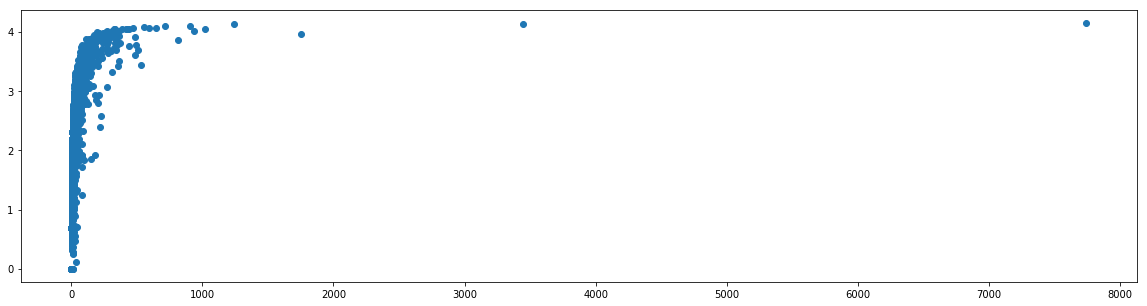

In [52]:
plt.subplots(figsize=(20,5))
plt.scatter([word_freq_darwin[w] for w in probs_w.keys()], probs_w.values())
plt.show()

### Generar una versión randomizada del texto, y medir la entropía de las palabras randomizadas

In [48]:
shuffled = random.sample(darwin_tokens, len(darwin_tokens))

report_entropies_parts(entropies_parts(shuffled, relevant_words, 32), relevant_words, 32)
report_entropies_parts(entropies_parts(shuffled, relevant_words, 64), relevant_words, 64)
report_entropies_parts(entropies_parts(shuffled, relevant_words, 128), relevant_words, 128)

probs_w_shuffled = entropies_parts(shuffled, set(shuffled), 64)


Entropy for 32 parts for word island 3.3825529116
Entropy for 32 parts for word instinct 3.38698440336
Entropy for 32 parts for word more 3.44303463388

Entropy for 64 parts for word island 3.99648961338
Entropy for 64 parts for word instinct 3.97823860316
Entropy for 64 parts for word more 4.10588045587

Entropy for 128 parts for word island 4.5037690239
Entropy for 128 parts for word instinct 4.36116345678
Entropy for 128 parts for word more 4.75401366504



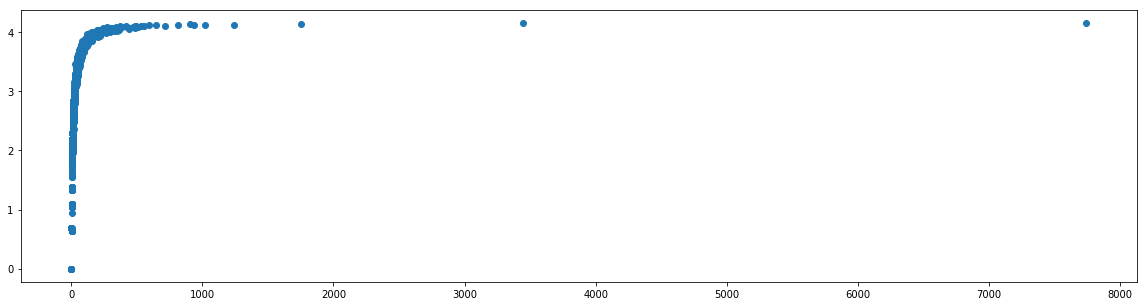

In [53]:
plt.subplots(figsize=(20,5))
plt.scatter([word_freq_darwin[w] for w in probs_w_shuffled.keys()], probs_w_shuffled.values())
plt.show()

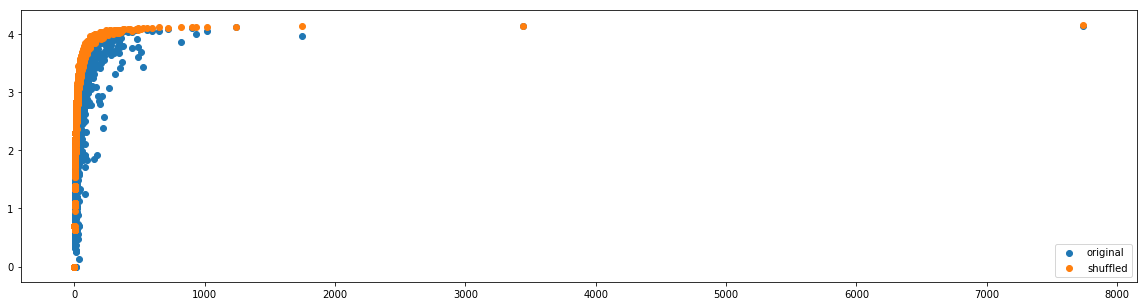

In [67]:
plt.subplots(figsize=(20,5))
plt.scatter([word_freq_darwin[w] for w in probs_w.keys()], probs_w.values(), label = 'original')
plt.scatter([word_freq_darwin[w] for w in probs_w_shuffled.keys()], probs_w_shuffled.values(), label = 'shuffled')
plt.legend()
plt.show()

### Distinguir las palabras del texto en artículos, sustantivos y adjetivos usando un POS-tagger. Verificar si las medidas separan a estos grupos de palabras

## Word embeddings, distancia semántica y WordNet

### Utilizando el test WordSim353, comparar el rendimiento entre LSA y Word2Vec

### Comparar los distintos word embeddings con las medidas definidas en WordNet